In [28]:
%matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import plots, params, models
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)


<module 'libs.models' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models.py'>

In [29]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

import torch
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [33]:
look_back      = params.look_back_tick
features_cols  = params.features_cols_tick
label_col      = params.label_col
device         = params.device

df_feat = pd.read_csv(params.feat_csv, index_col=0, parse_dates=True)

df_features = df_feat[features_cols + ['signal','ask','bid']]
df_features 


Using device: cuda


,vol_15,bb_width_20,hour,ma_20,macd_signal_9,low,atr_14,obv,vwap_dev,volume_spike,r_15,close,ma_5,open,high,ask,bid
2004-01-02 13:09:00,-0.808302,-0.760271,-0.759,-0.282361,0.265209,-0.028125,-1.435516,11.535427,-1.322490,0.520988,-0.023522,-0.193762,-0.185561,-0.193147,-0.317313,0.764464,0.764007
2004-01-02 13:10:00,-0.807178,-0.755313,-0.759,-0.284115,0.260467,-0.037500,-1.432540,11.491025,-1.322505,0.643761,-0.028905,-0.201725,-0.192087,-0.201085,-0.324262,0.764447,0.763990
2004-01-02 13:11:00,-0.806401,-0.750003,-0.759,-0.286307,0.254352,-0.046875,-1.429563,11.441197,-1.322519,0.730120,-0.034287,-0.209688,-0.200245,-0.209022,-0.331210,0.764431,0.763973
2004-01-02 13:12:00,-0.805908,-0.744446,-0.759,-0.288939,0.246985,-0.056250,-1.426587,11.385942,-1.322533,0.783493,-0.039669,-0.217651,-0.208402,-0.216960,-0.338159,0.764414,0.763957
2004-01-02 13:13:00,-0.805668,-0.738735,-0.759,-0.292008,0.238524,-0.065625,-1.423611,11.325262,-1.322545,0.808659,-0.045052,-0.225614,-0.216560,-0.224897,-0.345107,0.764397,0.763940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.124867,-0.088988,0.824,0.166276,1.090106,0.574157,1.564945,1.052590,6.801913,0.660240,0.886834,0.711538,0.459338,0.549591,0.685627,196.874000,196.756000
2025-06-18 20:57:00,0.162391,-0.047334,0.824,0.194941,1.163926,0.483840,1.725116,0.748311,6.795517,0.801959,0.749591,0.532051,0.532269,0.715746,0.787202,196.734000,196.616000
2025-06-18 20:58:00,0.147152,-0.013071,0.824,0.220771,1.223858,0.574157,1.732743,0.401350,6.795265,0.844139,0.555449,0.525641,0.560418,0.543200,0.533266,196.729000,196.611000
2025-06-18 20:59:00,0.375568,-0.010450,0.824,0.218881,1.212771,0.070963,1.970101,-0.969666,6.775591,4.087618,-0.069970,-0.025641,0.491325,0.549591,0.545962,196.298900,196.181100


In [4]:
# ──────────────────────────────────────────────────────────────────────────────
# Build LSTM input tensors (disk-backed memmaps)
#    Returns five tensors on `device`:
#      X        : (N, look_back, F)
#      y        : (N,)
#      raw_close: (N,)
#      raw_bid  : (N,)
#      raw_ask  : (N,)
# ──────────────────────────────────────────────────────────────────────────────
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df             = df_features,
    look_back      = look_back,
    features_cols  = features_cols,
    label_col      = label_col,
    regular_start  = params.regular_start_pred
)

print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y         =", y.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)

Shapes:
  X         = torch.Size([2433126, 60, 15]) (samples, look_back, features)
  y         = torch.Size([2433126]) (samples,)
  raw_close = torch.Size([2433126])
  raw_bid   = torch.Size([2433126])
  raw_ask   = torch.Size([2433126])


In [5]:
# ──────────────────────────────────────────────────────────────────────────────
#    (We use the helper `chronological_split` that returns)
#      (X_tr, y_tr),
#      (X_val, y_val),
#      (X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te)
# ──────────────────────────────────────────────────────────────────────────────
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df_features,
    look_back       = look_back,
    regular_start   = params.regular_start_pred,
    train_prop      = params.train_prop,
    val_prop        = params.val_prop,
    train_batch     = params.hparams['TRAIN_BATCH']
)

print("Shapes:")
print("  X_tr        =", X_tr.shape)
print("  y_tr        =", y_tr.shape)
print("  raw_close_te=", raw_close_te.shape)
print("  raw_bid_te  =", raw_bid_te.shape)
print("  raw_ask_te  =", raw_ask_te.shape)


Shapes:
  X_tr        = torch.Size([1702957, 60, 15])
  y_tr        = torch.Size([1702957])
  raw_close_te= torch.Size([364859])
  raw_bid_te  = torch.Size([364859])
  raw_ask_te  = torch.Size([364859])


In [6]:
# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df_features,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)


▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=1702957, val=365310, te=364859
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..809], total days=810
   te_day_id  ∈ [0..808], total days=809
4) instantiating DayWindowDatasets
   ds_tr days: 3776
   ds_val days: 810
   ds_te days: 809
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready


In [7]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────

def objective(trial):
    
    hp = {
    # ── Architecture ────────────────────────────────────────────────
    "DROPOUT_SHORT": trial.suggest_float("DROPOUT_SHORT", 0.0, 0.5),
    "DROPOUT_LONG":  trial.suggest_float("DROPOUT_LONG",  0.0, 0.5),
    "ATT_DROPOUT":   trial.suggest_float("ATT_DROPOUT",   0.0, 0.5),
    
    # ── Optimizer & Scheduler ──────────────────────────────────────
    "INITIAL_LR":    trial.suggest_float("INITIAL_LR",    1e-5, 1e-1),
    "ETA_MIN":       trial.suggest_float("ETA_MIN",       1e-6, 1e-3),
    "WEIGHT_DECAY":  trial.suggest_float("WEIGHT_DECAY",  1e-8, 1e-2),
    "CLIPNORM":      trial.suggest_float("CLIPNORM",      0.1, 5.0),
    }
    
    print(f"\n▶ Trial {trial.number} starting with:\n{hp}\n")#
    # Build model
    model = models.DualMemoryLSTM(
        n_feats       = len(features_cols),
        short_units   = params.hparams["SHORT_UNITS"],
        long_units    = params.hparams["LONG_UNITS"],
        dropout_short = hp["DROPOUT_SHORT"],
        dropout_long  = hp["DROPOUT_LONG"],
        att_drop      = hp["ATT_DROPOUT"],
    ).to(device)

    # Build optimizer + schedulers + scaler
    optimizer, plateau_sched, _ , scaler, clipnorm = \
        models.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )

    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=params.hparams['T_0'], 
        T_mult=params.hparams['T_MULT'], 
        eta_min=hp['ETA_MIN']
    )

    # Run training & return best validation RMSE
    best_rmse = models.custom_stateful_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams["MAX_EPOCHS"],
        early_stop_patience = params.hparams["EARLY_STOP_PATIENCE"],
        baseline_val_rmse   = baseline_val_rmse,
        clipnorm            = clipnorm,
        device              = device,
    )

    del model
    del optimizer
    del plateau_sched
    del cosine_sched
    del scaler

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return best_rmse



Training sees 3776 calendar days per epoch

Baseline (zero‐forecast) RMSE on validation = 0.004232


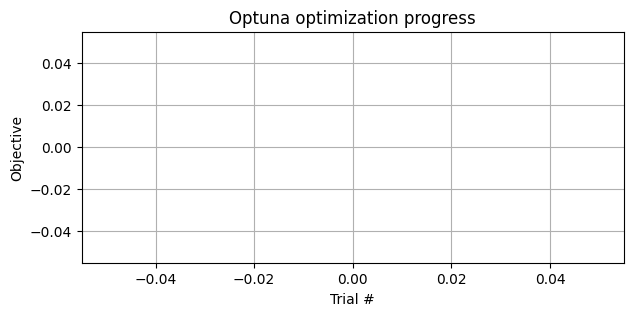

In [8]:
# -----------------------------------------------------------------------------
# Count how many calendar days we see each epoch and Compute baseline RMSE on validation (zero forecast)
# -----------------------------------------------------------------------------
n_train_days = len(train_loader.dataset)  # dataset length = # unique days
print(f"Training sees {n_train_days} calendar days per epoch\n")

baseline_val_rmse = models.naive_rmse(val_loader)
print(f"Baseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")

# ----------------------------------------------------------
# create ONE figure
# ----------------------------------------------------------
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-08-10 12:26:17,868] A new study created in RDB with name: no-name-638f1108-1d07-416b-9679-864bf6e3735a



▶ Trial 0 starting with:
{'DROPOUT_SHORT': 0.03510974509686243, 'DROPOUT_LONG': 0.24460444769585393, 'ATT_DROPOUT': 0.07540291281156208, 'INITIAL_LR': 0.044662388195578516, 'ETA_MIN': 0.0005185800529826918, 'WEIGHT_DECAY': 0.006235158300109575, 'CLIPNORM': 1.390675034659712}



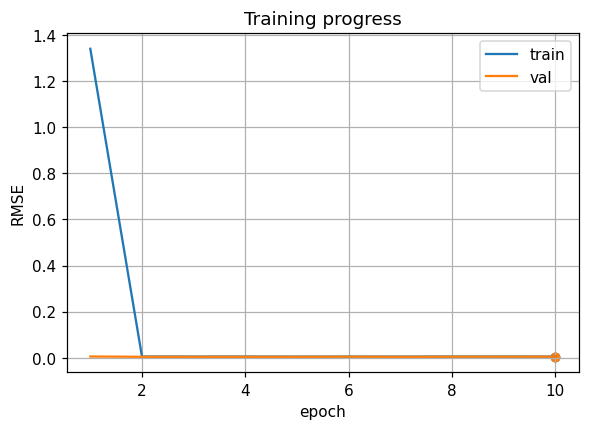

Epoch 1:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 001 • train=1.3392 • val=0.0055 • lr=4.46e-02


Epoch 2:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 002 • train=0.0055 • val=0.0044 • lr=4.45e-02


Epoch 3:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 003 • train=0.0054 • val=0.0044 • lr=4.44e-02


Epoch 4:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 004 • train=0.0054 • val=0.0045 • lr=4.42e-02


Epoch 5:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 005 • train=0.0052 • val=0.0044 • lr=4.39e-02


Epoch 6:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 006 • train=0.0053 • val=0.0049 • lr=4.36e-02


Epoch 7:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 007 • train=0.0053 • val=0.0044 • lr=4.32e-02


Epoch 8:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 008 • train=0.0054 • val=0.0048 • lr=4.28e-02


Epoch 9:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 009 • train=0.0054 • val=0.0048 • lr=4.23e-02


Epoch 10:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 010 • train=0.0053 • val=0.0051 • lr=4.17e-02


Epoch 11:   0%|          | 0/118 [00:00<?, ?bundle/s]

[W 2025-08-10 12:31:40,019] Trial 0 failed with parameters: {'DROPOUT_SHORT': 0.03510974509686243, 'DROPOUT_LONG': 0.24460444769585393, 'ATT_DROPOUT': 0.07540291281156208, 'INITIAL_LR': 0.044662388195578516, 'ETA_MIN': 0.0005185800529826918, 'WEIGHT_DECAY': 0.006235158300109575, 'CLIPNORM': 1.390675034659712} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_259/942174342.py", line 48, in objective
    best_rmse = models.custom_stateful_training_loop(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspace/my_models/Trading/_Stock_Analysis_/libs/models.py", line 899, in custom_stateful_training_loop
    out  = model(xb_days[di])         # (look_back, 1) prediction tensor
           ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packa

KeyboardInterrupt: 

In [9]:
# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

def cleanup_cb(study, trial):
    # Python‐side
    gc.collect()
    # CUDA‐side (no‐op on CPU only)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
study.optimize(
    objective,
    n_trials = 150,
    n_jobs   = 1,
    callbacks=[live_cb, cleanup_cb],
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{params.ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
